In this chapter you will work through an example project end to end, pretending to be a recently hired data scientist at a real estate company. 1 Here are the main steps you will go through:

1. Look at the big picture.
2. Get the data.
3. Discover and visualize the data to gain insights.
4. Prepare the data for Machine Learning algorithms.
5. Select a model and train it.
6. Fine-tune your model.
7. Present your solution.
8. Launch, monitor, and maintain your system.

## 1. Look at the Big Picture

Use california census data to build a model of housing prices in the state. This data includes metrics such as the population, median income, and median housing price for each block group in california. Block groups are the smallest geographical unit for  which the US Census Bureau publishes sample data (a block group typically has a population of 600 to 3000 people). We will call them "districts" for shot.

Your model should learn from this data and be able to predict the median housing price in any district, given all the other metrics.

- Frame the problem:

How does the company expect to use and benefit from this model? (business objective)
This model output will be fed to another ML system. This downstream system will determine whether it is worth investing in a given area or not. Getting this right is critical, as it directly affects revenue.

    - Pipeline

    Sequence of data processing components is called a data pipeline. manipulate and many data transformations to apply.

If any, what the current solution looks like? The current solution will often give you a reference for performance, as well as insights on how to solve the problem.

With all this information, you are now ready to start designing your system. First you need to *frame* te problem: is it supervised, unsupervised, or reinforcement learnin? Is it a classisfication , regression task or something else? Shoul you use batch learning or online learning techniques?

Have you found the answers? Let’s see: it is clearly a typical supervised
learning task, since you are given labeled training examples (each instance
comes with the expected output, i.e., the district’s median housing price). It is
also a typical regression task, since you are asked to predict a value. More
specifically, this is a multiple regression problem, since the system will use
multiple features to make a prediction (it will use the district’s population, the
median income, etc.). It is also a univariate regression problem, since we are
only trying to predict a single value for each district. If we were trying to
predict multiple values per district, it would be a multivariate regression
problem. Finally, there is no continuous flow of data coming into the system,
there is no particular need to adjust to changing data rapidly, and the data is
small enough to fit in memory, so plain batch learning should do just fine.

- Select a performance measure

A typical performance measure for regression problems is the Root Mean Square Error (RMSE). If there are many outliers districts, you may consider using the *mean absolute error*. (MAE)

- RMSE(**X**,h) = sqrt( 1/m sum( (h(x) - y)**2 ) )
- MAE(**X**,h) = 1/m sum( |h(x) - y| )

- Check the Assumptions

It is a good praticte to list and verfy the assumptions that have been made so far (by you or others)


## 2.Get the Data

In [8]:
import urllib, tarfile, os

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data():
    path = './data/'
    file_name = 'housing.tgz'
    urllib.request.urlretrieve(HOUSING_URL, path + file_name)
    housing_tgz = tarfile.open(path + file_name)
    housing_tgz.extractall(path)
    housing_tgz.close()

In [9]:
import pandas as pd

def load_housing_data(file_path):
    return pd.read_csv(file_path + 'housing.csv')

In [10]:
fetch_housing_data()
housing = load_housing_data('./data/')
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [11]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [12]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


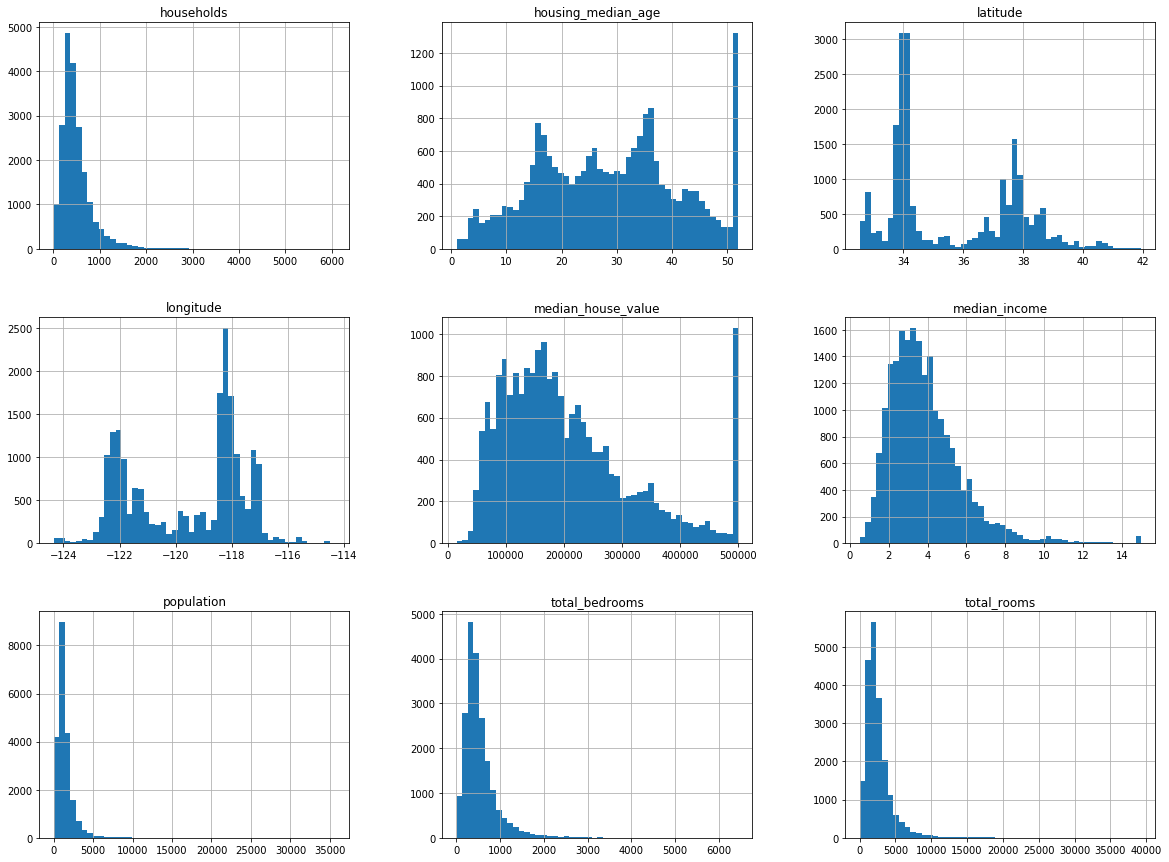

In [13]:
import matplotlib.pyplot as plt

housing.hist(bins=50, figsize=(20,15))
plt.show()

### Create a test set

In [14]:
import numpy as np

np.random.seed(0)

def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data)) # shuffled list of indices
    test_set_size = int(len(data) * test_ratio)         # calc the test set size
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [15]:
train_set, test_set = split_train_test(housing, 0.2)
train_set.shape, test_set.shape

((16512, 10), (4128, 10))

In [16]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

train_set.shape, test_set.shape 


((16512, 10), (4128, 10))

### Creating the income categorie

In [17]:
housing['income_cat'] = pd.cut(housing['median_income'], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1,2,3,4,5])

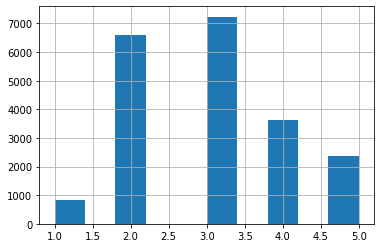

In [18]:
housing['income_cat'].hist()

In [20]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [24]:
strat_test_set['income_cat'].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [25]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop('income_cat', axis=1, inplace=True)

## 3.Discover and Visualize the Data to Gain Insights

- Only make this on the train set, if the train set are very large, you may want to sample and exploration set, to make manipulations easy and fast.

In [26]:
housing = strat_train_set.copy()

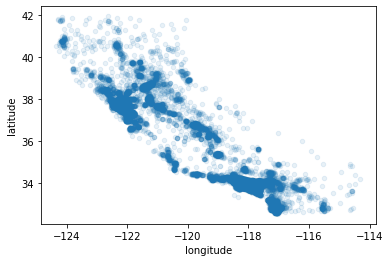

In [30]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1)
plt.show()

In [ ]:
# page 113